## A short analysis of the compressive strength of concrete. 
> Dataset from https://www.kaggle.com/datasets/sinamhd9/concrete-comprehensive-strength

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

df = pd.read_excel('data/Concrete_Data.xls')
df.info()

: 

array([[<AxesSubplot:title={'center':'Cement (component 1)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Fly Ash (component 3)(kg in a m^3 mixture)'}>],
       [<AxesSubplot:title={'center':'Water  (component 4)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Superplasticizer (component 5)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Coarse Aggregate  (component 6)(kg in a m^3 mixture)'}>],
       [<AxesSubplot:title={'center':'Fine Aggregate (component 7)(kg in a m^3 mixture)'}>,
        <AxesSubplot:title={'center':'Age (day)'}>,
        <AxesSubplot:title={'center':'Concrete compressive strength(MPa, megapascals) '}>]],
      dtype=object)

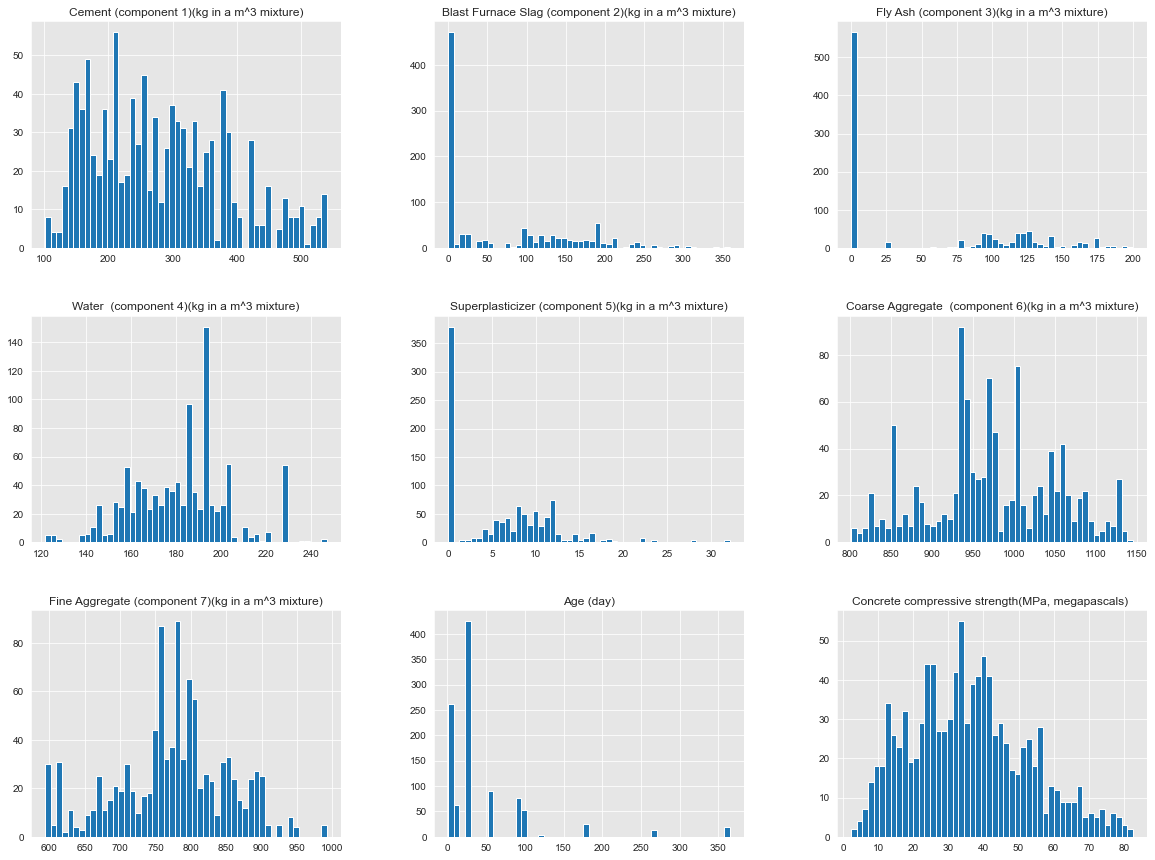

: 

In [ ]:
df.hist(bins=50, figsize=(20, 15))

strength            1.000000
cement              0.497833
superplasticizer    0.366102
age                 0.328877
slag                0.134824
ash                -0.105753
coarse_agg         -0.164928
fine_agg           -0.167249
water              -0.289613
Name: strength, dtype: float64

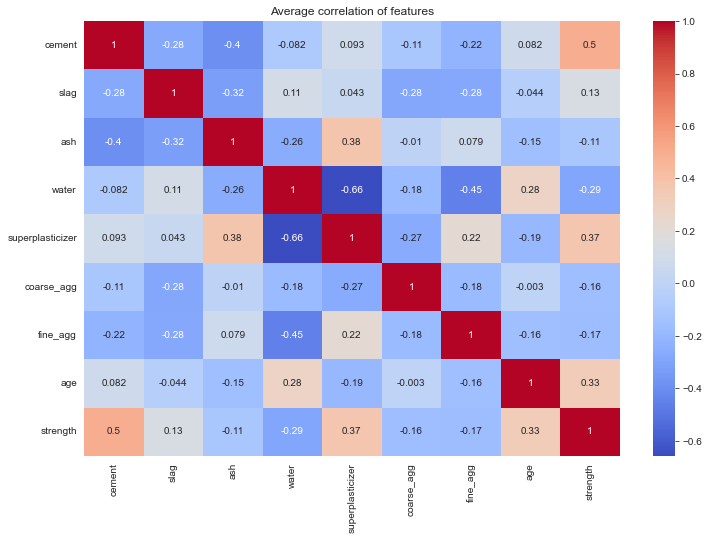

: 

In [ ]:
df.columns = ['cement', 'slag', 'ash', 'water', 'superplasticizer', 'coarse_agg', 'fine_agg', 'age', 'strength']

plt.figure(figsize=(12, 8))
plt.title('Average correlation of features')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

df.corr()['strength'].sort_values(ascending=False)


In [ ]:
def calc_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index = X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

: 

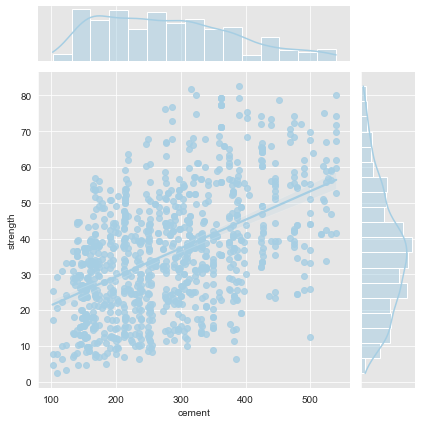

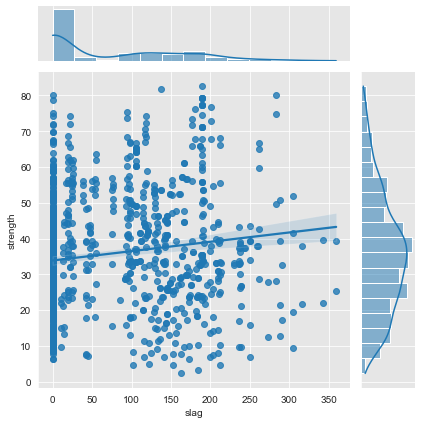

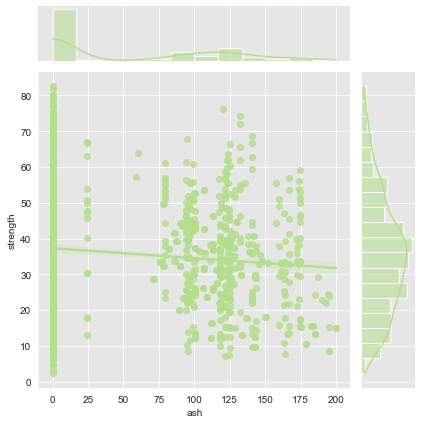

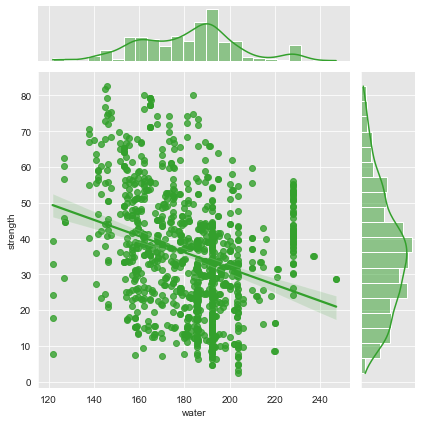

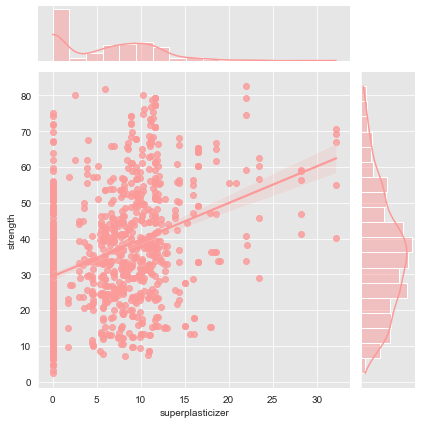

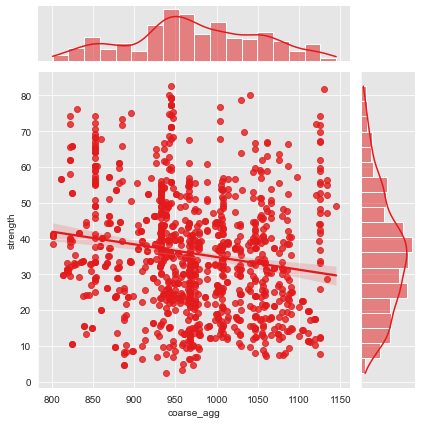

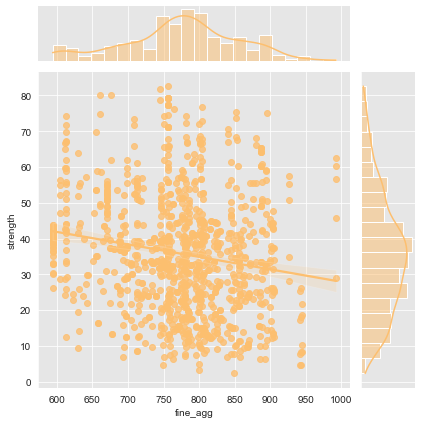

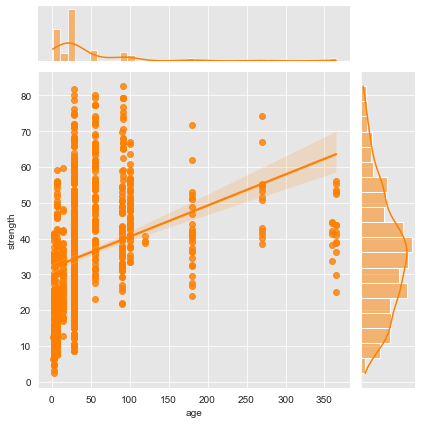

: 

In [ ]:
columns = df.columns.drop(['strength'])

for i in range(len(columns)):
    sns.jointplot(x=columns[i],
                  y='strength',
                  data=df,
                  kind='reg',
                  color=sns.color_palette("Paired", 8)[i])
    
plt.show()

In [ ]:
fe_df = df.copy()

fe_X = fe_df.drop(['strength'], axis=1)
fe_y = fe_df['strength']

fe_mi_scores = calc_mi_scores(fe_X, fe_y)
fe_mi_scores

age                 0.362263
water               0.357109
cement              0.304292
coarse_agg          0.257789
superplasticizer    0.221007
fine_agg            0.212369
slag                0.179260
ash                 0.123430
Name: MI Scores, dtype: float64

: 

In [ ]:
fe_df['total'] = df.drop(['strength'], axis=1).sum(axis=1)

fe_df['cement_ratio'] = fe_df['cement'] / fe_df['total']

fe_df['water_ratio'] = fe_df['water'] / fe_df['total']

fe_df['agg_ratio'] = (fe_df['coarse_agg'] + fe_df['fine_agg']) / fe_df['total']

fe_df.head()

,cement,slag,ash,water,superplasticizer,coarse_agg,fine_agg,age,strength,total,cement_ratio,water_ratio,agg_ratio
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111,2448.5,0.220543,0.066163,0.700837
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366,2463.5,0.219200,0.065760,0.702659
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535,2499.0,0.133053,0.091236,0.610644
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780,2594.0,0.128180,0.087895,0.588281
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075,2686.9,0.073914,0.071458,0.671368


: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('strength', axis=1), df['strength'], test_size=0.2, random_state=0)

model = LinearRegression()
scaler = StandardScaler()
steps = [('scaler', scaler), ('regressor', model)]
pipeline = Pipeline(steps)

cv_results = cross_val_score(pipeline, X_train, y_train, cv=10)
print(cv_results)
np.mean(cv_results)

[0.57652993 0.62303922 0.63103482 0.5849102  0.5273293  0.61677468
 0.51247014 0.68659326 0.54133102 0.65621386]


0.5956226437077508

: 

In [ ]:
def model_tester(df, models):
    for i in range(len(models)):
        X_train, X_test, y_train, y_test = train_test_split(df.drop('strength', axis=1), df['strength'], test_size=0.2, random_state=0)
        model = models[i]
        model.fit(X_train, y_train)
        
        print(f'{model.__class__.__name__} score: {model.score(X_test, y_test)}')

: 

In [ ]:
models = [LinearRegression(), Lasso(alpha=0.1)]

model_tester(fe_df, models)

LinearRegression score: 0.6834885078379929
Lasso score: 0.636974378033547


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 483.2779924827919, tolerance: 23.258623112598062
  model = cd_fast.enet_coordinate_descent(


: 